In [2]:
from google.cloud import storage
import pandas as pd
import numpy as np
from scipy.io import mmread
import pyreadr
import anndata
import matplotlib.pyplot as plt
from collections import defaultdict, Counter, OrderedDict

import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
import umap

def log_normalize(counts):
    ms = counts.sum(axis=1)
    norm_df = counts.div(ms, axis=0).mul(np.median(ms),axis=0)
    data_df = np.log(norm_df + 0.1)
    data_df = data_df.astype(np.float32)
    return data_df

In [3]:
# bucket_name = 'car-t-data'
# storage_client = storage.Client()
# bucket = storage_client.get_bucket(bucket_name)

# my_prefix = "rstudio-export-metadata/" # the name of the subfolder
# blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

# for blob in blobs:
#     print(blob)
#     if(blob.name != my_prefix): # ignoring the subfolder itself 
#         file_name = blob.name.replace(my_prefix, "") 
#         blob.download_to_filename(file_name) # download the file to the machine

In [40]:
# df = pd.read_csv("01_card_filtered.csv").transpose()
# meta = pd.read_csv("01_card_filtered_METADATA.csv")
# new_barcodes = []
# for barcode in df.index:
#     cell = meta.loc[barcode]
#     cell_time = cell['time']
#     experiment = cell['experiment']
#     original_barcode = barcode.split("-")[0]
#     string = "CAR"+experiment+"_"+cell_time+"_"+original_barcode
#     new_barcodes.append(string)
    
# df.index = new_barcodes
# df.to_pickle("card.pkl")

In [41]:
# cara = pd.read_pickle("cara.pkl")
# carb = pd.read_pickle("carb.pkl")
# carc = pd.read_pickle("carc.pkl")
# card = pd.read_pickle("card.pkl")
# counts = pd.concat([cara,carb,carc,card])

In [ ]:
counts = pd.read_pickle("car_t_counts.pkl")

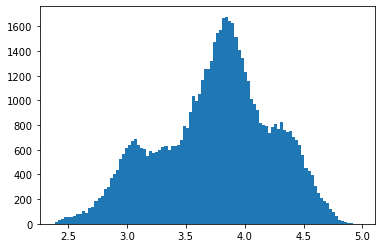

In [5]:
ms = counts.sum(axis = 1)
plt.hist(np.log10(ms), bins = 100)
plt.show()

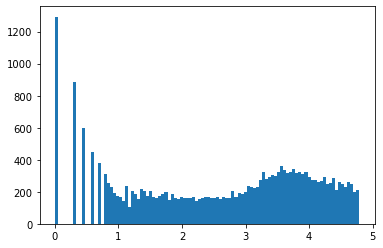

In [8]:
binary = np.sign(counts)
ms_gene = binary.sum(axis = 0)
ms_gene = ms_gene[ms_gene>0]
plt.hist(np.log10(ms_gene), bins = 100)
plt.show()

In [9]:
counts = counts[ms_gene.index]
# counts.to_pickle("counts_nonzero_genes.pkl")

In [10]:
data_df = log_normalize(counts)
data_df.to_pickle("data_df_car_t.pkl")

In [11]:
# filter out noisy genes for PCA

# counts.to_pickle("counts_nonzero_genes.pkl")
use_genes = ms_gene.index[ms_gene>=1]
counts = counts[use_genes]
filtered = log_normalize(counts)


In [29]:
pca = PCA(n_components=100)
pca.fit(counts)
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0:10]

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

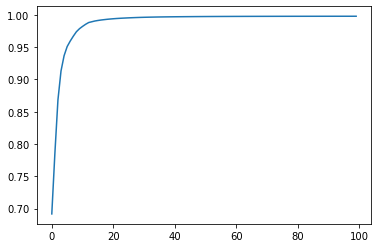

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [19]:
adata = sc.AnnData(data_df)
sc.pp.pca(adata,n_comps = 15)
sc.pp.neighbors(adata)

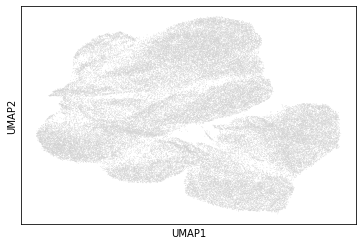

In [36]:
# sc.tl.umap(adata)
sc.pl.umap(adata)

In [37]:
adata

AnnData object with n_obs × n_vars = 61437 × 22294
    uns: 'pca', 'neighbors', 'umap', 'library_size'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

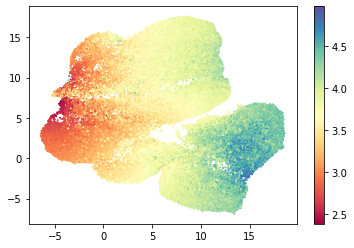

In [40]:
umap_2 = pd.DataFrame(adata.obsm['X_umap'], columns = ['x','y'])
plt.figure()
plt.scatter(umap_2['x'],umap_2['y'], s = 1, cmap=plt.get_cmap('Spectral'), c = np.log10(ms+0.1))
plt.colorbar()
plt.show()

In [1]:
pca = PCA(n_components=15)
pca_projections = pd.DataFrame(pca.fit_transform(filtered), index = filtered.index)
umap_data = umap.UMAP()
results = umap_data.fit_transform(pca_projections);
umap_ = pd.DataFrame(results, index=filtered.index, columns=['x', 'y'])
# umap_.to_pickle("car_t_umap.pkl")

NameError: name 'PCA' is not defined

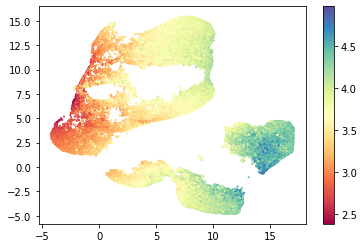

In [17]:
plt.figure()
plt.scatter(umap_['x'],umap_['y'], s = 1, cmap=plt.get_cmap('Spectral'), c = np.log10(ms+0.1))
plt.colorbar()
plt.show()

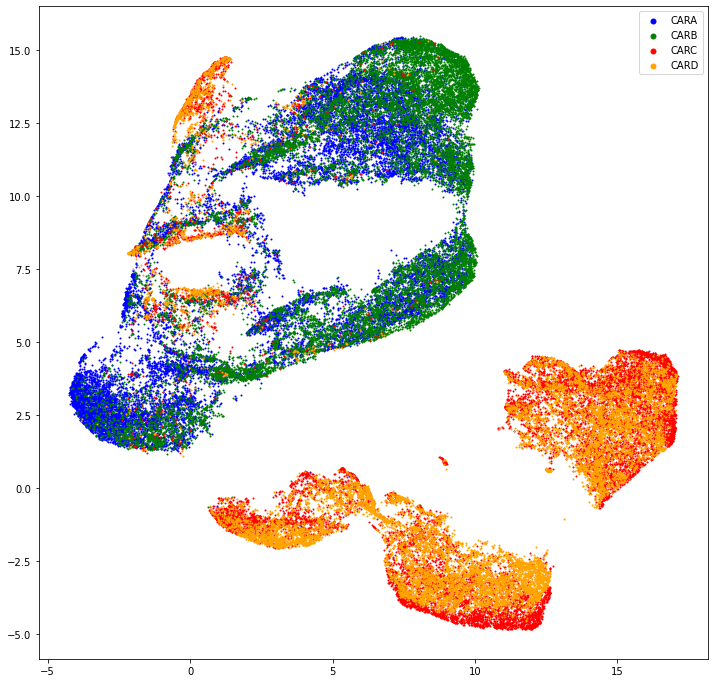

In [63]:
experiments = ['CARA','CARB','CARC','CARD']
col_arr = ["blue", 'green','red','orange']

plt.figure(figsize = [12,12])
for i,exp in enumerate(experiments):
    cells = umap_.index[umap_.index.str.contains(exp)]
    plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'], s = 1, label = exp, color = col_arr[i])
plt.legend(markerscale = 5)
plt.show()
    
    

In [51]:
umap_2.index = umap_.index

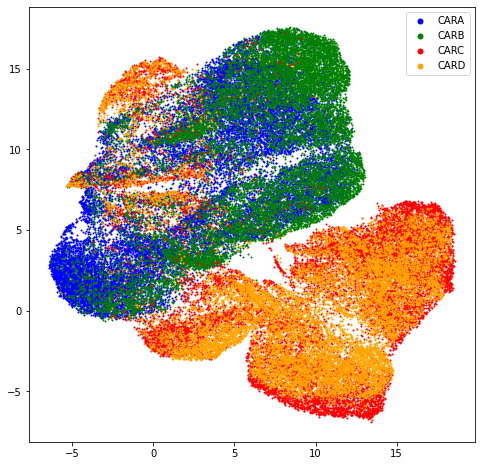

In [52]:
experiments = ['CARA','CARB','CARC','CARD']
col_arr = ["blue", 'green','red','orange']
DF = umap_2
plt.figure(figsize = [8,8])
for i,exp in enumerate(experiments):
    cells = DF.index[DF.index.str.contains(exp)]
    plt.scatter(DF.loc[cells,'x'],DF.loc[cells,'y'], s = 1, label = exp, color = col_arr[i])
plt.legend(markerscale = 5)
plt.show()
    

In [71]:
umap_

,x,y
CARA_T9_AAACCTGAGAATAGGG,-0.854431,4.830726
CARA_T5_AAACCTGAGACAGGCT,-3.054501,1.719231
CARA_T4_AAACCTGAGACCGGAT,2.042165,7.307134
CARA_T9_AAACCTGAGAGGTACC,0.196699,9.207946
CARA_T1_AAACCTGAGCGAAGGG,6.289377,13.234041
...,...,...
CARD_T7_TTTGTCATCCGTTGCT,5.692782,0.139906
CARD_T6_TTTGTCATCCTCGCAT,10.336457,-1.840803
CARD_T6_TTTGTCATCGGAGGTA,-1.995758,8.020425
CARD_T7_TTTGTCATCGTAGGAG,15.998152,3.770051


In [94]:
cell = umap_.index[0]
a = cell.split("_")[1][0:2]
b = np.where(time == 'T9')


In [111]:
umap_ = pd.read_pickle("car_t_umap.pkl")

In [112]:
umap_

,x,y
CARA_T9_AAACCTGAGAATAGGG,-0.854431,4.830726
CARA_T5_AAACCTGAGACAGGCT,-3.054501,1.719231
CARA_T4_AAACCTGAGACCGGAT,2.042165,7.307134
CARA_T9_AAACCTGAGAGGTACC,0.196699,9.207946
CARA_T1_AAACCTGAGCGAAGGG,6.289377,13.234041
...,...,...
CARD_T7_TTTGTCATCCGTTGCT,5.692782,0.139906
CARD_T6_TTTGTCATCCTCGCAT,10.336457,-1.840803
CARD_T6_TTTGTCATCGGAGGTA,-1.995758,8.020425
CARD_T7_TTTGTCATCGTAGGAG,15.998152,3.770051


In [115]:
time = ["T0","T1","T2","T3","T4","T5","T6","T7","T8","T9"]
color_set = ['magenta','violet','mediumorchid','mediumpurple','blue',
             'darkblue','royalblue','cornflowerblue','lightblue','cyan']
DF = umap_
DF['c'] = np.nan
for cell in umap_.index:
    time_sample = cell.split("_")[1][0:2]
    ind = time.index(time_sample)
    DF.loc[cell,'c'] = color_set[ind]


In [116]:
DF.to_pickle("umap_with_time_colors.pkl")

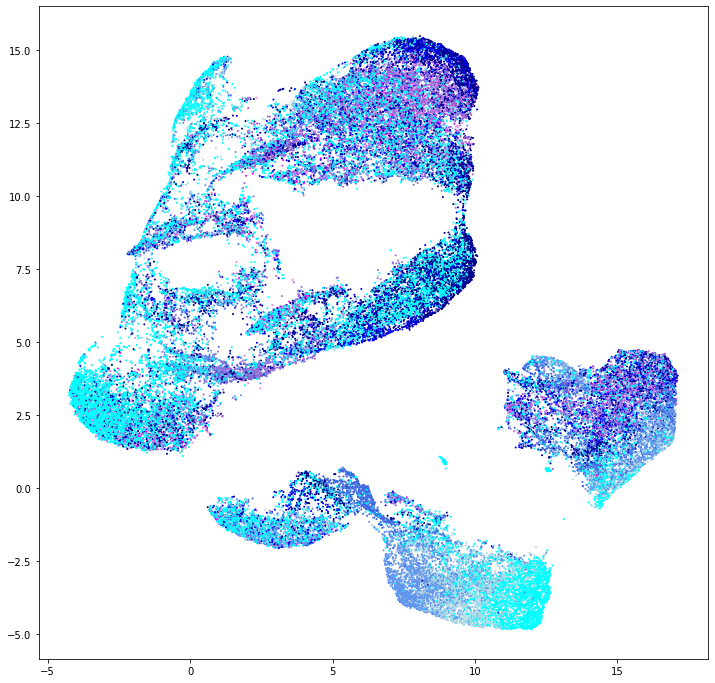

In [117]:

DF = DF.sample(frac = 1)

plt.figure(figsize = [12,12])
plt.scatter(DF['x'],DF['y'], s = 1, color = DF['c'])
plt.show()
    